In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.stats import truncnorm, uniform
from astroML.stats import mean_sigma
from astroML.resample import bootstrap
from astroML.plotting.mcmc import convert_to_stdev
from scipy.stats import norm, anderson
from astroML.stats import mean_sigma, median_sigmaG

## 5.6 Simple Examples of Bayesian Analysis: Parameter Estimation

### MLE vs Bayesian Estimation

##### MLE: 
* We sought a point value for a parameter that maximized the likelihood
* No priors
* Probability statements about parameters were meaningless

##### Bayesian Estimation: 
* We maximize the posterior to get a probability density function for the parameters(s) rather than a single point
* We can update data with prior assumptions to make probability statements about the parameters


### Parameter Estimation for a Gaussian Distribution

#### Known errors

Suppose we have a set of $N$ values $\{x_{i}\}$ drawn from a Gaussian distribution with known errors $\sigma_{i}$. If $\{x_{i}\}$ are i.i.d., the likelihood of the entire data set is just the product of the likelihood for each particular value: 

$$ p(\{x_i\}\,|\,\mu,\,I) = {\displaystyle \prod_{i=1}^{N}} \, \frac{1}{\sqrt{2\pi}\sigma_i} \mbox{exp}\Big(\frac{-(x_i-\mu)^2}{2\sigma_i^2}\Big) $$

If we take our prior to be uniform such that in the range $\mu_{min}<\mu<\mu_{max}$

$$p(\mu|I)=C,\hspace{1cm}$$
where $$C=(\mu_{max}-\mu_{min})^{-1}$$

then the posterior pdf for the parameter $\mu$ is

$$ p(\mu|\{x_i\}, \{\sigma_i\},I) = p(\{x_i\}|\mu,I)\,p(\mu|I)$$

and its logarithm is

$$ L_p\equiv\mbox{ln}[p(\mu|\{x_i\}, \{\sigma_i\},I)] = \mbox{constant} - {\displaystyle \sum_{i=1}^{N}} \frac{(x_i-\mu)^2}{2\sigma_i^2}$$

Maximizing the parameter $\mu$ via $dL_p/d\mu|_{\mu=\mu_0}=0$ gives

$$ \mu_0=\frac{\Sigma_{i=1}^{N}w_ix_i}{\Sigma_{i=1}^{N}w_i} $$

and the width of the posterior pdf for $\mu$ is 

$$ \sigma_\mu=\Big(-\frac{d^2L_p}{d\mu^2}|_{\mu=\mu_0}\Big)^{-1/2}=\Big({\displaystyle \sum_i}w_i\Big)^{-1/2}$$

 
We see that using a flat prior gave us the same result as the maximum likelihood estimation. If we had assumed our errors were homoscedastic, this would just reduce to the standard result given by

$$ \mu_0=\frac{1}{N}{\displaystyle \sum_{i=1}^N}x_i$$


Conclusion: when errors are known, the posterior pdf for $\mu$ is Gaussian. What happens when $\sigma$ is unknown?

#### Unknown errors (two-dimentional posterior)

Now the $\sigma$ needs to be determined from the data. We can interpret $\sigma$ as the intrinsic spread of the measured quantity (assuming individual measurement errors are negligible) or we can equivalently say that all measurements have the same unknown precision. 

When N is large, we can assume Gaussian uncertainty of $\mu$ with its width given by

$$ \sigma_{\bar{x}}=\frac{s}{\sqrt{N}} $$

For small N, however, the posterior pdf for $\mu$ follows a different distribution. To determine what this distribution is we first write likelihood

$$ p(\{x_i\}\,|\,\mu,\sigma,\,I) = {\displaystyle \prod_{i=1}^{N}} \, \frac{1}{\sqrt{2\pi}\sigma} \mbox{exp}\Big(\frac{-(x_i-\mu)^2}{2\sigma^2}\Big) $$

where $\sigma$ is unknown and homoscedastic. Assuming uniform priors for $\mu$ and $\sigma$, 

$$ p(\mu, \sigma|I)\,\propto\,\frac{1}{\sigma} $$ 

we get (after some normalization)

$$ L_p = \mbox{constant} - (N+1)\,\mbox{ln}\sigma-{\displaystyle \sum_{i=1}^{N}} \frac{(x_i - \mu)^2}{2\sigma^2}$$

Making the substitution $V=N^{-1}\Sigma_{i=1}^{N}(x_i-\bar{x})^2$, the posterior becomes

$$ L_p = \mbox{constant} - (N+1)\,\mbox{ln}\sigma - \frac{N}{2\sigma^2}((\bar{x}-\mu)^2 + V)$$

$L_p$ is rewritten in terms of $(N, \bar{x}, V)$ because they fully capture the entire information content of the data set. They are called $\textit{sufficient}$ statistics for this reason. 

Once again, we can find the position of the maximum ($\mu_0,\sigma_0$) by setting $dL_p/d\mu|_{\mu=\mu_0} = 0$ and  $dL_p/d\sigma|_{\sigma=\sigma_0} = 0$ to get

$$ \mu_0=\bar{x} $$


$$ \sigma_0=\Big(\frac{VN}{N+1}\Big)^{1/2}= \sqrt{\frac{1}{N-1}{\displaystyle \sum_{i=1}^{N}}(x_i-\bar{x})^2}$$

The latter is just the sample standard deviation. 

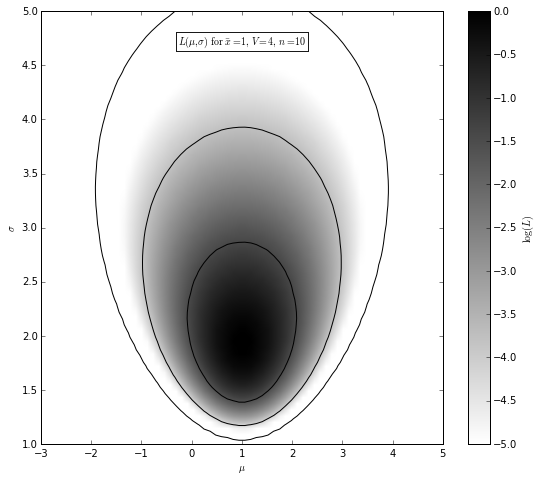

In [4]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

def gauss_logL(xbar, V, n, sigma, mu):
    """Equation 5.58: gaussian likelihood"""
    return (-(n + 1) * np.log(sigma)
            - 0.5 * n * ((xbar - mu) ** 2 + V) / sigma ** 2)

#------------------------------------------------------------
# Define the grid and compute logL
sigma = np.linspace(1, 5, 70)
mu = np.linspace(-3, 5, 70)
xbar = 1
V = 4
n = 10

logL = gauss_logL(xbar, V, n, sigma[:, np.newaxis], mu)
logL -= logL.max()

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(9, 7.75))
plt.imshow(logL, origin='lower',
           extent=(mu[0], mu[-1], sigma[0], sigma[-1]),
           cmap=plt.cm.binary,
           aspect='auto')

plt.colorbar().set_label(r'$\log(L)$')
plt.clim(-5, 0)

plt.contour(mu, sigma, convert_to_stdev(logL),
            levels=(0.683, 0.955, 0.997),
            colors='k')

plt.text(0.5, 0.93, r'$L(\mu,\sigma)\ \mathrm{for}\ \bar{x}=%d,\ V=%d,\ n=%d$'%(xbar,V,n),
         bbox=dict(ec='k', fc='w', alpha=0.9),
         ha='center', va='center', transform=plt.gca().transAxes)

plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$');

If we knew the width of our distribution $\sigma$, then the posterior probability $p(\mu|\sigma)$ would be Gaussian. However we don't know $\sigma$, so we have to marginalize our posterior by integrating over all possible values of $\sigma$

$$ p(\mu|\{x_i\}, I)=\int_0^\infty p(\mu, \sigma|\{x_i\}, I)\,d\sigma$$

which gives a marginal pdf for $p(\mu)$ which is proportional to 

$$ p(\mu|\{x_i\}, I) \propto \Big[1+\frac{(\bar{x}-\mu)^2}{V}\Big]^{-N/2} $$

Thus in cases when N is small and the errors are unkown and homoscedastic, the underlying distribution for the posterior follows a Student'ts $t$ distribution.  

In the limit of large N, this essentially approaches a Gaussian. Moreover, marginalizing with repsect to $\mu$ gives a posterior pdf for $\sigma$ that resembles a $\chi^2$ distribution

$$ p(\sigma|\{x_i\}, I) \propto \frac{1}{\sigma^N}\mbox{exp}\Big(\frac{-NV}{w\sigma^2}\Big) $$

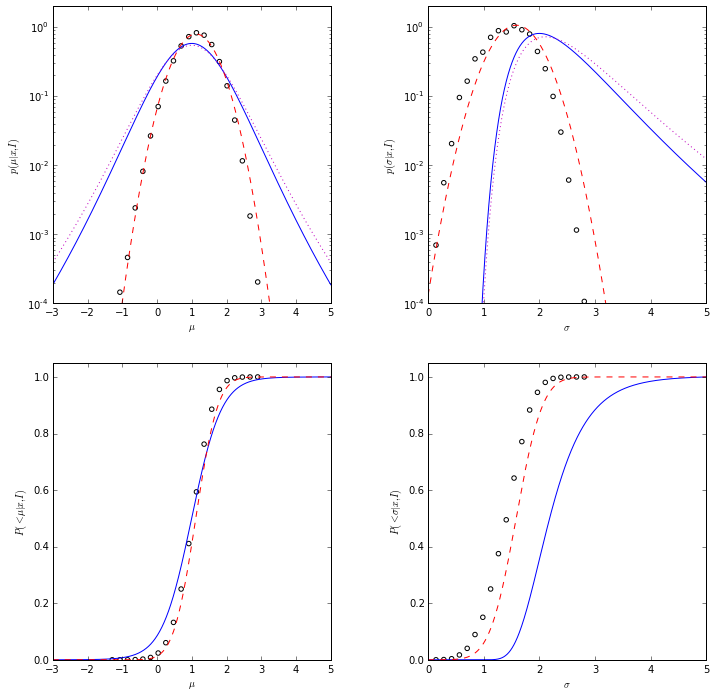

In [6]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general



#------------------------------------------------------------
# Define functions for computations below
#  These are expected analytic fits to the posterior distributions
def compute_pmu(mu, xbar, V, n):
    return (1 + (xbar - mu) ** 2 / V) ** (-0.5 * n)


def compute_pmu_alt(mu, xbar, V, n):
    return (1 + (xbar - mu) ** 2 / V) ** (-0.5 * (n - 1))


def compute_psig(sig, V, n):
    return (sig ** -n) * np.exp(-0.5 * n * V / sig ** 2)


def compute_psig_alt(sig, V, n):
    return (sig ** -(n - 1)) * np.exp(-0.5 * n * V / sig ** 2)


def gaussian(x, mu, sigma):
    return np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)


#------------------------------------------------------------
# Draw a random sample from the distribution, and compute
# some quantities
n=10
#n = 77
xbar = 1
V = 4
sigma_x = np.sqrt(V)

np.random.seed(10)
xi = np.random.normal(xbar, sigma_x, size=n)

mu_mean, sig_mean = mean_sigma(xi, ddof=1)

# compute the analytically expected spread in measurements
mu_std = sig_mean / np.sqrt(n)
sig_std = sig_mean / np.sqrt(2 * (n - 1))

#------------------------------------------------------------
# bootstrap estimates
mu_bootstrap, sig_bootstrap = bootstrap(xi, 1E6, mean_sigma,
                                        kwargs=dict(ddof=1, axis=1))

#------------------------------------------------------------
# Compute analytic posteriors

# distributions for the mean
mu = np.linspace(-3, 5, 1000)
dmu = mu[1] - mu[0]

pmu = compute_pmu(mu, xbar, V, n)
pmu /= (dmu * pmu.sum())

pmu2 = compute_pmu_alt(mu, xbar, V, n)
pmu2 /= (dmu * pmu2.sum())

pmu_norm = gaussian(mu, mu_mean, mu_std)
pmu_norm /= (dmu * pmu_norm.sum())

mu_hist, mu_bins = np.histogram(mu_bootstrap, 20)
mu_dbin = np.diff(mu_bins).astype(float)
mu_hist = mu_hist / mu_dbin / mu_hist.sum()

# distributions for the standard deviation
sig = np.linspace(1E-4, 5, 1000)
dsig = sig[1] - sig[0]
psig = compute_psig(sig, V, n)
psig /= (dsig * psig.sum())

psig2 = compute_psig_alt(sig, V, n)
psig2 /= (dsig * psig2.sum())

psig_norm = gaussian(sig, sig_mean, sig_std)
psig_norm /= (dsig * psig_norm.sum())

sig_hist, sig_bins = np.histogram(sig_bootstrap, 20)
sig_dbin = np.diff(sig_bins).astype(float)
sig_hist = sig_hist / sig_dbin / sig_hist.sum()

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(11, 11))
fig.subplots_adjust(wspace=0.35, right=0.95,
                    hspace=0.2, top=0.95)

# plot posteriors for mu
ax1 = plt.subplot(221, yscale='log')
ax1.plot(mu, pmu, '-b')
ax1.plot(mu, pmu2, ':m')
ax1.plot(mu, pmu_norm, '--r')
ax1.scatter(mu_bins[1:] - 0.5 * mu_dbin, mu_hist,
            edgecolor='k', facecolor='none')

ax1.set_xlabel(r'$\mu$')
ax1.set_ylabel(r'$p(\mu|x,I)$')

ax2 = plt.subplot(223, sharex=ax1)
ax2.plot(mu, pmu.cumsum() * dmu, '-b')
ax2.plot(mu, pmu_norm.cumsum() * dmu, '--r')
ax2.scatter(mu_bins[1:] - 0.5 * mu_dbin, mu_hist.cumsum() * mu_dbin,
            edgecolor='k', facecolor='none')
ax2.set_xlim(-3, 5)

ax2.set_xlabel(r'$\mu$')
ax2.set_ylabel(r'$P(<\mu|x,I)$')

# plot posteriors for sigma
ax3 = plt.subplot(222, sharey=ax1)
ax3.plot(sig, psig, '-b')
ax3.plot(sig, psig2, ':m')
ax3.plot(sig, psig_norm, '--r')
ax3.scatter(sig_bins[1:] - 0.5 * sig_dbin, sig_hist,
            edgecolor='k', facecolor='none')
ax3.set_ylim(1E-4, 2)

ax3.set_xlabel(r'$\sigma$')
ax3.set_ylabel(r'$p(\sigma|x,I)$')

ax4 = plt.subplot(224, sharex=ax3, sharey=ax2)
ax4.plot(sig, psig.cumsum() * dsig, '-b')
ax4.plot(sig, psig_norm.cumsum() * dsig, '--r')
ax4.scatter(sig_bins[1:] - 0.5 * sig_dbin, sig_hist.cumsum() * sig_dbin,
            edgecolor='k', facecolor='none')
ax4.set_ylim(0, 1.05)
ax4.set_xlim(0, 5)

ax4.set_xlabel(r'$\sigma$')
ax4.set_ylabel(r'$P(<\sigma|x,I)$');

### General Case

* Data drawn from some distribution
* Known heteroscedastic measurment errors
* Unknown intrinsic spread

Following the same procedure as before, the posterior is given by

$$ p(\{x_i\}|\mu, \sigma, I)={\displaystyle \prod_{i=1}^{N}} \frac{1}{\sqrt{2\pi}(\sigma^2+e_i^2)^{1/2}}\mbox{exp}\Big(\frac{-(x_i-\mu)^2}{2(\sigma^2+e_i^2)}\Big)$$

$$ L_p = \mbox{constant} - \frac{1}{2}{\displaystyle \sum_{i=1}^{N}} \Big(\mbox{ln}(\sigma^2+e_i^2)+\frac{(x_i-\mu)^2}{\sigma^2+e_i^2}\Big) $$

* $\sigma$ is coupled to $e_i$
* Underlying distribution of {$x_i$} is no longer Gaussian -- weighted sum of Gaussians with varying widths

/Users/belaabolfathi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/belaabolfathi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


anderson-darling A^2 = 3088.1


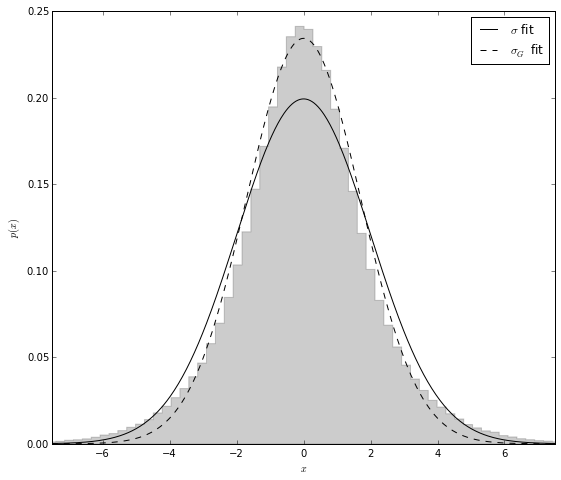

In [14]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from __future__ import print_function

#------------------------------------------------------------
# Create distributions

# draw underlying points
np.random.seed(0)
Npts = 1E6
x = np.random.normal(loc=0, scale=1, size=Npts)

# add error for each point
e = 3 * np.random.random(Npts)
x += np.random.normal(0, e)

# compute anderson-darling test
A2, sig, crit = anderson(x)
print("anderson-darling A^2 = %.1f" % A2)

# compute point statistics
mu_sample, sig_sample = mean_sigma(x, ddof=1)
med_sample, sigG_sample = median_sigmaG(x)

#------------------------------------------------------------
# plot the results
fig, ax = plt.subplots(figsize=(9, 7.75))
ax.hist(x, 100, histtype='stepfilled', alpha=0.2,
        color='k', normed=True)

# plot the fitting normal curves
x_sample = np.linspace(-15, 15, 1000)
ax.plot(x_sample, norm(mu_sample, sig_sample).pdf(x_sample),
        '-k', label='$\sigma$ fit')
ax.plot(x_sample, norm(med_sample, sigG_sample).pdf(x_sample),
        '--k', label='$\sigma_G$ fit')
ax.legend()

ax.set_xlim(-7.5, 7.5)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$');

Taking the derivative of $L_p$ with respect to $\mu$ and setting it to zero gives a maximum value for $\mu=\mu_0$

$$ \mu_0=\frac{\Sigma_i w_i x_i}{\Sigma_i w_i} $$

but with different weights 

$$ w_i = \frac{1}{\sigma_0^2 + e_i^2} $$

We can provide an additional constraint for $\sigma_0$ by setting the derivative of $L_p$ with respect to $\sigma$ equal to zero, but this does not lead to a closed form expression and requires simulatenously solving two complicated equations. Instead, the sample median is actually a pretty good estimator of $\mu_0$, and the maximum width can be estimated as 

$$ \sigma_0^2=\zeta^2\sigma_G^2-e_{50}^2 $$

where $\sigma_G$ is the quartile-based estimator, $e_{50}$ is the median error, and $\zeta=\mbox{median}(\tilde{\sigma_i})/\mbox{mean}(\tilde{\sigma_i})$, where

$$ \tilde{\sigma_i} = (\sigma_G^2+e_i^2-e_{50}^2)^{1/2} $$

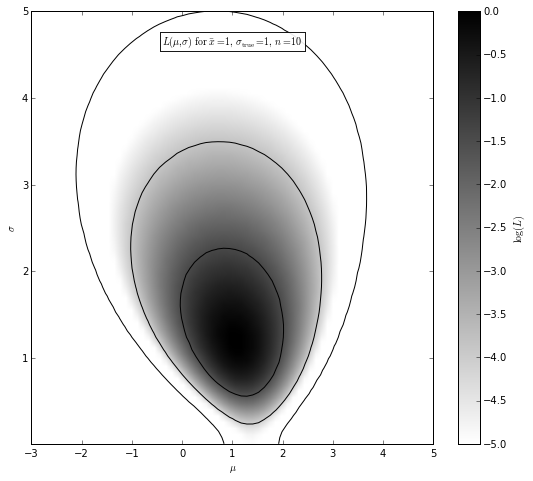

In [11]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general


def gaussgauss_logL(xi, ei, mu, sigma):
    """Equation 5.63: gaussian likelihood with gaussian errors"""
    ndim = len(np.broadcast(sigma, mu).shape)

    xi = xi.reshape(xi.shape + tuple(ndim * [1]))
    ei = ei.reshape(ei.shape + tuple(ndim * [1]))

    s2_e2 = sigma ** 2 + ei ** 2
    return -0.5 * np.sum(np.log(s2_e2) + (xi - mu) ** 2 / s2_e2, 0)

#------------------------------------------------------------
# Define the grid and compute logL
np.random.seed(5)
mu_true = 1.
sigma_true = 1.
N = 10
ei = 3 * np.random.random(N)
xi = np.random.normal(mu_true, np.sqrt(sigma_true ** 2 + ei ** 2))

sigma = np.linspace(0.01, 5, 70)
mu = np.linspace(-3, 5, 70)

logL = gaussgauss_logL(xi, ei, mu, sigma[:, np.newaxis])
logL -= logL.max()

#------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(9, 7.75))
plt.imshow(logL, origin='lower',
           extent=(mu[0], mu[-1], sigma[0], sigma[-1]),
           cmap=plt.cm.binary,
           aspect='auto')
plt.colorbar().set_label(r'$\log(L)$')
plt.clim(-5, 0)

plt.text(0.5, 0.93,
         (r'$L(\mu,\sigma)\ \mathrm{for}\ \bar{x}=1,\ '
          r'\sigma_{\rm true}=1,\ n=10$'),
         bbox=dict(ec='k', fc='w', alpha=0.9),
         ha='center', va='center', transform=plt.gca().transAxes)

plt.contour(mu, sigma, convert_to_stdev(logL),
            levels=(0.683, 0.955, 0.997),
            colors='k')

plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$');

Because the errors are heteroscedastic, the posterior pdf is no longer symmetric with respect to $\mu$.

### Gaussian and a Uniform Background

This time we have a distribution that is a mixture of a Gaussian and a uniform distribution in some interval $W$. This could, for example, represent a profile of a source in an image with an unkown background. Assuming $\mu$ is known we seek the posterior pdf for $A$ (the strength of the background) and $\sigma$. The likelihood of obtaining a measurement $x_i$ is 

$$p(x_i|A, \mu, \sigma) = \frac{A}{\sqrt{2\pi}\sigma}\mbox{exp}\Big(\frac{-(x_i-\mu)^2}{2\sigma^2}\Big)+\frac{1-A}{W} $$

Taking the prior to be 

$$ p(A, \sigma|I) = \mbox{constant} $$ 

and requiring $A$ and $\sigma$ to be non-negative, we get 

$$ L_p={\displaystyle \sum_{i=1}^N}\mbox{ln}\Big[A\frac{\mbox{exp}\Big(\frac{-(x_i-\mu)^2}{2\sigma^2}\Big)}{\sqrt{2\pi}\sigma}+\frac{1-A}{W}\Big] $$

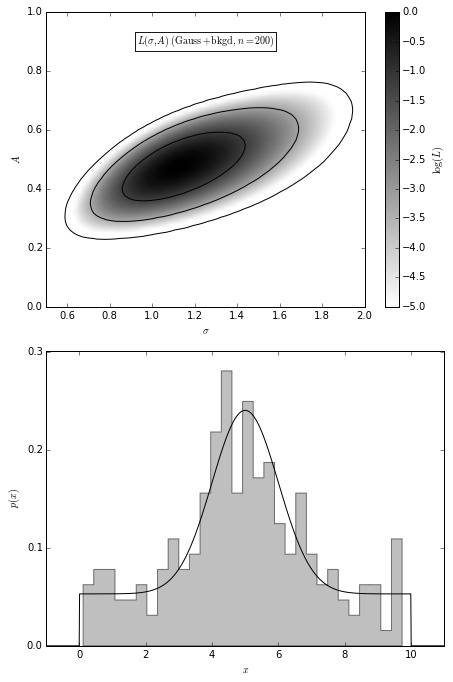

In [12]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

def gausslin_logL(xi, A=0.5, sigma=1.0, mu=5.0, L=10.0):
    """Equation 5.80: gaussian likelihood with uniform background"""
    xi = np.asarray(xi)

    shape = np.broadcast(sigma, A, mu, L).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    return np.sum(np.log(A * np.exp(-0.5 * ((xi - mu) / sigma) ** 2)
                         / (sigma * np.sqrt(2 * np.pi))
                         + (1. - A) / L), 0)

#------------------------------------------------------------
# Define the distribution
np.random.seed(0)
mu = 5.0
sigma = 1.0
L = 10.0
A = 0.5
N = 200

xi = np.random.random(N)
NA = np.sum(xi < A)

dist1 = truncnorm((0 - mu) / sigma, (L - mu) / sigma, mu, sigma)
dist2 = uniform(0, 10)

xi[:NA] = dist1.rvs(NA)
xi[NA:] = dist2.rvs(N - NA)

x = np.linspace(-1, 11, 1000)
fracA = NA * 1. / N

#------------------------------------------------------------
# define the (sigma, A) grid and compute logL
sigma = np.linspace(0.5, 2, 70)
A = np.linspace(0, 1, 70)

logL = gausslin_logL(xi, A[:, np.newaxis], sigma)
logL -= logL.max()

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(7, 10))
fig.subplots_adjust(bottom=0.07, left=0.11, hspace=0.15, top=0.95)

ax = fig.add_subplot(211)
plt.imshow(logL, origin='lower', aspect='auto',
           extent=(sigma[0], sigma[-1], A[0], A[-1]),
           cmap=plt.cm.binary)
plt.colorbar().set_label(r'$\log(L)$')
plt.clim(-5, 0)
ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$A$')

ax.text(0.5, 0.9, r'$L(\sigma,A)\ (\mathrm{Gauss + bkgd},\ n=200)$',
        bbox=dict(ec='k', fc='w', alpha=0.9),
        ha='center', va='center', transform=plt.gca().transAxes)

ax.contour(sigma, A, convert_to_stdev(logL),
           levels=(0.683, 0.955, 0.997),
           colors='k')

ax2 = plt.subplot(212)
ax2.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax2.plot(x, fracA * dist1.pdf(x) + (1. - fracA) * dist2.pdf(x), '-k')
ax2.hist(xi, 30, normed=True, histtype='stepfilled', fc='gray', alpha=0.5)

ax2.set_ylim(0, 0.301)
ax2.set_xlim(-1, 11)

ax2.set_xlabel('$x$')
ax2.set_ylabel('$p(x)$');